# Real-world numba: creating a skeleton analysis library

- what is skeleton analysis
- what skan does
- a bit about API design
- what is numba
- what are the limits of performance

## What is skan

- https://jni.github.io/skan

In [119]:
DATADIR = '/home/jni/projects/skan/doc/schizonts'

In [122]:
import os
import imageio as iio

image = iio.imread(os.path.join(DATADIR, 'schizont4_iRBC10_02.tif'),
                   format='fei')

<IPython.core.display.Javascript object>


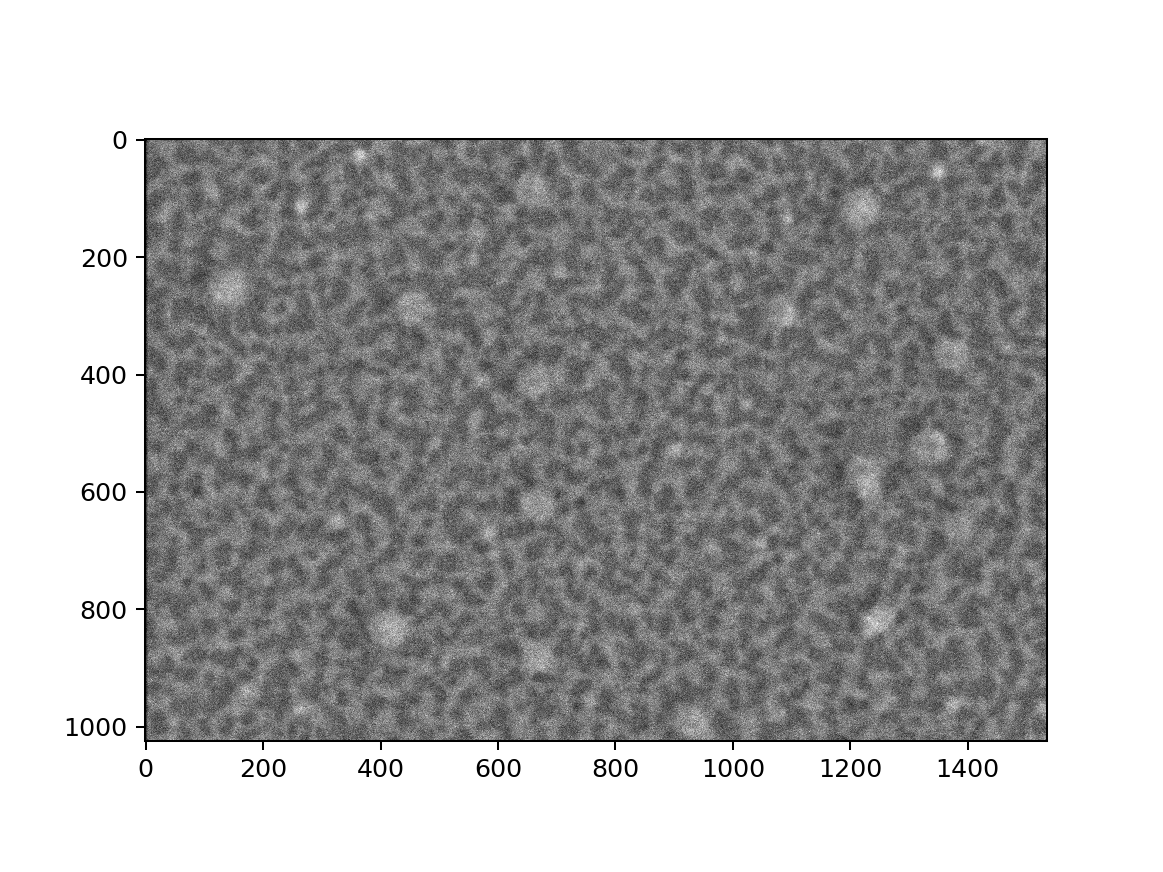

In [124]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.imshow(image, cmap='gray');

In [ ]:
from skan import pre

## Whiteboard: Sauvola thresholding

## Timing various bits of the inner loop

In [51]:
import itertools
import numpy as np
from scipy import ndimage as ndi
from skimage.transform import integral_image
from skimage import util
from skimage.util import dtype_limits
import numba


@numba.jit(nopython=True, nogil=True, fastmath=True)
def _correlate_sparse_loop(input, indices, offsets,
                           values, output):
    for i, j in enumerate(indices):
        for off, val in zip(offsets, values):
            output[i] += input[j + off] * val


def correlate_sparse(image, kernel):
    indices = np.nonzero(kernel)
    offsets = np.ravel_multi_index(indices, image.shape)
    values = kernel[indices].astype(image.dtype)
    result = np.zeros([a - b + 1
                       for a, b in zip(image.shape, kernel.shape)],
                      dtype=image.dtype)
    corner_multi_indices = np.meshgrid(*[np.arange(i)
                                         for i in result.shape],
                                       indexing='ij',
                                       sparse=True)
    corner_indices = np.ravel_multi_index(corner_multi_indices,
                                          image.shape).ravel()
    _correlate_sparse_loop(
        image.ravel(), corner_indices, offsets, values,
        result.ravel()
    )
    return result

In [75]:
#image = np.random.random((256, 256, 256))
#w = 63
image = np.random.random((4000, 6000))
w = 301
kern = np.zeros((w + 1,) * image.ndim)
for indices in itertools.product(*([[0, -1]] * image.ndim)):
    kern[indices] = (-1) ** (image.ndim % 2 != np.sum(indices) % 2)

In [76]:
indices = np.nonzero(kern)
offsets = np.ravel_multi_index(indices, image.shape)
values = kern[indices].astype(image.dtype)
result = np.zeros([a - b + 1
                   for a, b in zip(image.shape, kern.shape)],
                  dtype=image.dtype)
corner_multi_indices = np.meshgrid(*[np.arange(i)
                                     for i in result.shape],
                                   indexing='ij',
                                   sparse=True)
corner_indices = np.ravel_multi_index(corner_multi_indices,
                                      image.shape).ravel()

In [77]:
# warmup jit
_correlate_sparse_loop(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

In [78]:
%%timeit -n 5 -r 5 -o
_correlate_sparse_loop(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

540 ms ± 6.3 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


<TimeitResult : 540 ms ± 6.3 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)>

In [79]:
len(corner_indices), len(offsets)

(21080601, 4)

In [80]:
max(offsets)

1806301

In [82]:
# M elems per second:
time = 0.540
len(corner_indices) * len(offsets) / time / 1e6

156.1526

In [83]:
@numba.jit(nopython=True, nogil=True, fastmath=True)
def _correlate_sparse_offsets(input, indices, offsets, values, output):
    for off, val in zip(offsets, values):
        # this loop order optimises cache access, gives up to 10x speedup
        for i, j in enumerate(indices):
            output[i] += input[j + off] * val 

In [84]:
# warmup jit
_correlate_sparse_offsets(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

In [85]:
%%timeit -n 5 -r 5
_correlate_sparse_offsets(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

132 ms ± 11.8 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [87]:
# M elems per second:
time = 0.132
len(corner_indices) * len(offsets) / time / 1e6

638.8060909090909

In [88]:
def print_lines(substring, string):
    lines = string.split('\n')
    for line in lines:
        if substring in line:
            print(line)

In [89]:
asm = list(_correlate_sparse_offsets.inspect_asm().values())[0]
print('single instructions:', asm.count('sd'))
print('double instructions:', asm.count('pd'))
print_lines('sd', asm)

single instructions: 19
double instructions: 0
	vmovsd	(%rax,%rcx,8), %xmm0
	vmovsd	%xmm0, 8(%rsp)
	vmovsd	8(%rsp), %xmm1
	vmovsd	8(%rsp), %xmm1
	vmovsd	(%r14,%rdx,8), %xmm0
	vfmadd213sd	(%r13,%rax,8), %xmm1, %xmm0
	vmovsd	%xmm0, (%r13,%rax,8)
	vmovsd	(%r14,%rdx,8), %xmm0
	vfmadd213sd	8(%r13,%rax,8), %xmm1, %xmm0
	vmovsd	%xmm0, 8(%r13,%rax,8)
	vmovsd	(%r14,%rdx,8), %xmm0
	vfmadd213sd	16(%r13,%rax,8), %xmm1, %xmm0
	vmovsd	%xmm0, 16(%r13,%rax,8)
	vmovsd	(%r14,%rdx,8), %xmm0
	vfmadd213sd	24(%r13,%rax,8), %xmm1, %xmm0
	vmovsd	%xmm0, 24(%r13,%rax,8)
	vmovsd	(%r14,%rdi,8), %xmm0
	vfmadd213sd	(%rcx,%rdx), %xmm1, %xmm0
	vmovsd	%xmm0, (%rcx,%rdx)


In [90]:
@numba.jit(nopython=True, nogil=True, fastmath=True)
def _correlate_no_indirection(input, indices, offsets, values, output):
    for off, val in zip(offsets, values):
        for i in range(len(indices)):
            output[i] += input[i + off] * val


In [91]:
# warmup jit
_correlate_no_indirection(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

In [92]:
%%timeit -n 5 -r 5
_correlate_no_indirection(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

93.9 ms ± 1.89 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [93]:
# M elems per second:
time = 0.094
len(corner_indices) * len(offsets) / time / 1e6

897.0468510638298

In [94]:
asm = list(_correlate_no_indirection.inspect_asm().values())[0]
print('single instructions:', asm.count('sd'))
print('double instructions:', asm.count('pd'))
print_lines('pd', asm)

single instructions: 32
double instructions: 26
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 280(%rsp)
	vmovapd	%ymm0, 256(%rsp)
	vmovupd	%ymm0, 408(%rsp)
	vmovapd	%ymm0, 384(%rsp)
	vmovupd	%ymm0, 216(%rsp)
	vmovapd	%ymm0, 192(%rsp)
	vmovupd	%ymm0, 152(%rsp)
	vmovapd	%ymm0, 128(%rsp)
	vmovupd	%ymm0, 344(%rsp)
	vmovapd	%ymm0, 320(%rsp)
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 280(%rsp)
	vmovapd	%ymm0, 256(%rsp)
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 408(%rsp)
	vmovapd	%ymm0, 384(%rsp)
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 216(%rsp)
	vmovapd	%ymm0, 192(%rsp)
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 152(%rsp)
	vmovapd	%ymm0, 128(%rsp)
	vxorpd	%xmm0, %xmm0, %xmm0
	vmovupd	%ymm0, 344(%rsp)
	vmovapd	%ymm0, 320(%rsp)


In [95]:
@numba.jit(nopython=True, nogil=True, fastmath=True)
def _correlate_no_indir_offset(input, indices, offsets, values, output):
    for off, val in zip(offsets, values):
        for i in range(len(indices)):
            output[i] += input[i] * val


In [96]:
# warmup jit
_correlate_no_indir_offset(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

In [107]:
%%timeit -n 5 -r 5
_correlate_no_indir_offset(
    image.ravel(), corner_indices, offsets, values,
    result.ravel()
)

98.4 ms ± 921 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [108]:
asm = list(_correlate_no_indir_offset.inspect_asm().values())[0]
print('single instructions:', asm.count('sd'))
print('double instructions:', asm.count('pd'))
print_lines('pd', asm)

single instructions: 10
double instructions: 98
	vmovupd	(%rdx,%r12,8), %ymm2
	vmovupd	32(%rdx,%r12,8), %ymm3
	vmovupd	64(%rdx,%r12,8), %ymm4
	vmovupd	96(%rdx,%r12,8), %ymm5
	vfmadd213pd	(%rax,%r12,8), %ymm1, %ymm2
	vfmadd213pd	32(%rax,%r12,8), %ymm1, %ymm3
	vfmadd213pd	64(%rax,%r12,8), %ymm1, %ymm4
	vfmadd213pd	96(%rax,%r12,8), %ymm1, %ymm5
	vmovupd	%ymm2, (%rax,%r12,8)
	vmovupd	%ymm3, 32(%rax,%r12,8)
	vmovupd	%ymm4, 64(%rax,%r12,8)
	vmovupd	%ymm5, 96(%rax,%r12,8)
	vmovupd	128(%rdx,%r12,8), %ymm2
	vmovupd	160(%rdx,%r12,8), %ymm3
	vmovupd	192(%rdx,%r12,8), %ymm4
	vmovupd	224(%rdx,%r12,8), %ymm5
	vfmadd213pd	128(%rax,%r12,8), %ymm1, %ymm2
	vfmadd213pd	160(%rax,%r12,8), %ymm1, %ymm3
	vfmadd213pd	192(%rax,%r12,8), %ymm1, %ymm4
	vfmadd213pd	224(%rax,%r12,8), %ymm1, %ymm5
	vmovupd	%ymm2, 128(%rax,%r12,8)
	vmovupd	%ymm3, 160(%rax,%r12,8)
	vmovupd	%ymm4, 192(%rax,%r12,8)
	vmovupd	%ymm5, 224(%rax,%r12,8)
	vmovupd	(%rdx,%r12,8), %ymm2
	vmovupd	32(%rdx,%r12,8), %ymm3
	vmovupd	64(%rdx,%r12,8), %y

In [109]:
image32 = image.astype(np.float32)
result32 = result.astype(np.float32)
values32 = values.astype(np.float32)

In [110]:
# warmup jit
_correlate_sparse_offsets(
    image32.ravel(), corner_indices, offsets, values32,
    result32.ravel()
)

In [116]:
%%timeit -n 5 -r 5
_correlate_sparse_offsets(
    image32.ravel(), corner_indices, offsets, values32,
    result32.ravel()
)

83.1 ms ± 1.65 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [118]:
# M elems per second:
time = 0.049
len(corner_indices) * len(offsets) / time / 1e6

1720.865387755102

In [117]:
%%timeit -n 5 -r 5
_correlate_no_indir_offset(
    image32.ravel(), corner_indices, offsets, values32,
    result32.ravel()
)

48.9 ms ± 978 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [115]:
asm = list(_correlate_no_indir_offset.inspect_asm().values())[1]
print('single instructions:', asm.count('ss'))
print('double instructions:', asm.count('ps'))
print_lines('ps', asm)

single instructions: 15
double instructions: 98
	vmovups	(%rdx,%r12,4), %ymm2
	vmovups	32(%rdx,%r12,4), %ymm3
	vmovups	64(%rdx,%r12,4), %ymm4
	vmovups	96(%rdx,%r12,4), %ymm5
	vfmadd213ps	(%rax,%r12,4), %ymm1, %ymm2
	vfmadd213ps	32(%rax,%r12,4), %ymm1, %ymm3
	vfmadd213ps	64(%rax,%r12,4), %ymm1, %ymm4
	vfmadd213ps	96(%rax,%r12,4), %ymm1, %ymm5
	vmovups	%ymm2, (%rax,%r12,4)
	vmovups	%ymm3, 32(%rax,%r12,4)
	vmovups	%ymm4, 64(%rax,%r12,4)
	vmovups	%ymm5, 96(%rax,%r12,4)
	vmovups	128(%rdx,%r12,4), %ymm2
	vmovups	160(%rdx,%r12,4), %ymm3
	vmovups	192(%rdx,%r12,4), %ymm4
	vmovups	224(%rdx,%r12,4), %ymm5
	vfmadd213ps	128(%rax,%r12,4), %ymm1, %ymm2
	vfmadd213ps	160(%rax,%r12,4), %ymm1, %ymm3
	vfmadd213ps	192(%rax,%r12,4), %ymm1, %ymm4
	vfmadd213ps	224(%rax,%r12,4), %ymm1, %ymm5
	vmovups	%ymm2, 128(%rax,%r12,4)
	vmovups	%ymm3, 160(%rax,%r12,4)
	vmovups	%ymm4, 192(%rax,%r12,4)
	vmovups	%ymm5, 224(%rax,%r12,4)
	vmovups	(%rdx,%r12,4), %ymm2
	vmovups	32(%rdx,%r12,4), %ymm3
	vmovups	64(%rdx,%r12,4), %y